In [157]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
shapefile_path = "kycells05g/kycells05g.shp"
gdf = gpd.read_file(shapefile_path)
print(gdf.head())

   CC83XCOORD  CC83YCOORD  CELLSYMB  \
0  -87.612162   37.456436         4   
1  -82.175694   37.456213         2   
2  -84.759818   37.456264         1   
3  -87.105100   37.456329         4   
4  -87.713574   37.456204         4   

                                            geometry  
0  POLYGON ((-87.61633 37.46033, -87.60718 37.459...  
1  POLYGON ((-82.17957 37.46028, -82.17049 37.459...  
2  POLYGON ((-84.76492 37.45312, -84.76384 37.460...  
3  POLYGON ((-87.10924 37.46024, -87.1001 37.4595...  
4  POLYGON ((-87.71775 37.46009, -87.7086 37.4594...  


In [3]:
print("\n--- Shapefile Metadata ---")
print(gdf.info())
print("\n--- Coordinate Reference System (CRS) ---")
print(gdf.crs)
print("\n--- Column Names ---")
print(gdf.columns)
print("\n--- Geometry Type ---")
print(gdf.geom_type.value_counts())
print(f"\nTotal Number of Features: {len(gdf)}")


--- Shapefile Metadata ---
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32478 entries, 0 to 32477
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CC83XCOORD  32478 non-null  float64 
 1   CC83YCOORD  32478 non-null  float64 
 2   CELLSYMB    32478 non-null  int64   
 3   geometry    32478 non-null  geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 1015.1 KB
None

--- Coordinate Reference System (CRS) ---
GEOGCS["DD_NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]

--- Column Names ---
Index(['CC83XCOORD', 'CC83YCOORD', 'CELLSYMB', 'geometry'], dtype='object')

--- Geometry Type ---
Polygon    32478
Name: count, dtype: int64

Total Number of Features: 32478


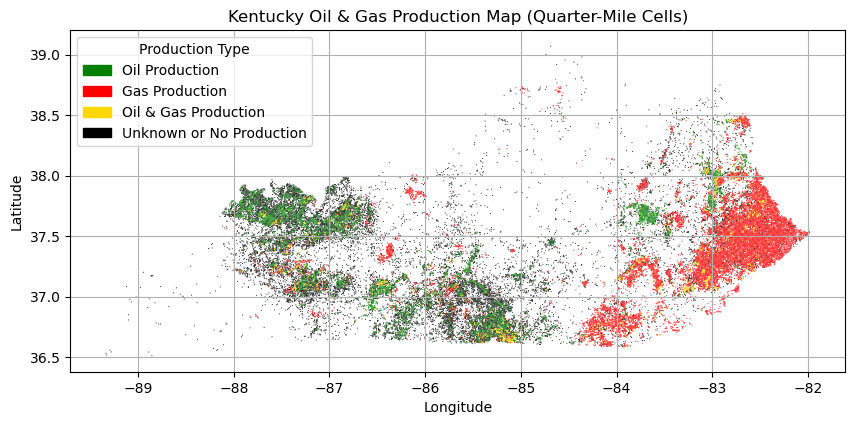

In [159]:
# Define production types and corresponding colors
production_labels = {
    1: "Oil Production",
    2: "Gas Production",
    3: "Oil & Gas Production",
    4: "Unknown or No Production"
}

production_colors = {
    1: "green",
    2: "red",
    3: "gold",
    4: "black"
}

# Plot the oil and gas production map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each category separately
for prod_type, color in production_colors.items():
    subset = gdf[gdf["CELLSYMB"] == prod_type]
    subset.plot(ax=ax, color=color, label=production_labels[prod_type])

# Manually create legend patches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in zip(production_labels.values(), production_colors.values())]
ax.legend(handles=legend_patches, loc="upper left", title="Production Type")

# Add titles and labels
ax.set_title("Kentucky Oil & Gas Production Map (Quarter-Mile Cells)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

plt.show()

In [5]:
import numpy as np
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Point

In [6]:

# Extract coordinates and production labels
X = gdf["CC83XCOORD"].values
Y = gdf["CC83YCOORD"].values
labels = gdf["CELLSYMB"].values  # 1: Oil, 2: Gas, 3: Both, 4: Unknown

In [7]:

# Convert categorical labels into indicators
oil_indicator = (gdf['CELLSYMB'] == 1).astype(int)  # 1 if oil, else 0
gas_indicator = (gdf['CELLSYMB'] == 2).astype(int)  # 1 if gas, else 0
both_indicator = (gdf['CELLSYMB'] == 3).astype(int)  # 1 if both, else 0

In [135]:
# Define the kriging grid (extent of the dataset)
grid_x = np.linspace(X.min(), X.max(), 40)  # Adjust resolution if needed
grid_y = np.linspace(Y.min(), Y.max(), 50)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

In [136]:
# Randomly sample 100 points for each category
np.random.seed(42)  # For reproducibility
sample_size = 1500

In [137]:
def sample_points(X, Y, indicator):
    """Randomly sample points from the dataset while maintaining spatial variability."""
    indices = np.where(indicator == 1)[0]  # Get indices of relevant category
    if len(indices) > sample_size:
        sampled_indices = np.random.choice(indices, sample_size, replace=False)
    else:
        sampled_indices = indices  # Use all available points if less than sample_size
    return X[sampled_indices], Y[sampled_indices], indicator[sampled_indices]

In [138]:
# Sampled points for each category
X_oil, Y_oil, oil_sample = sample_points(X, Y, oil_indicator)
X_gas, Y_gas, gas_sample = sample_points(X, Y, gas_indicator)
X_both, Y_both, both_sample = sample_points(X, Y, both_indicator)

In [140]:
# Ensure valid points (remove NaN and duplicates)
def clean_data(x, y, values):
    """Remove NaN and duplicate points to avoid Kriging errors."""
    mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(values)
    x, y, values = x[mask], y[mask], values[mask]
    
    unique_points = np.unique(np.column_stack((x, y)), axis=0)
    if len(unique_points) < 5:  # PyKrige needs at least 5 unique points
        print("Not enough unique points for kriging, skipping...")
        return None, None, None
    return x, y, values

In [141]:
X_oil, Y_oil, oil_sample = clean_data(X_oil, Y_oil, oil_sample)
X_gas, Y_gas, gas_sample = clean_data(X_gas, Y_gas, gas_sample)
X_both, Y_both, both_sample = clean_data(X_both, Y_both, both_sample)

In [148]:
# Function to perform ordinary kriging and return both estimate & variance
def perform_kriging(x, y, values, grid_x, grid_y, var_model="linear", var_nugg=0.1, var_range=4, var_sill=0.99, var_slope=0.3):
    """Perform Indicator Kriging on sampled data and return interpolated probabilities & variance."""
    if x is None or len(x) < 5:  # Skip if not enough data
        return np.full((len(grid_y), len(grid_x)), np.nan), np.full((len(grid_y), len(grid_x)), np.nan)
    
    try:
        if var_model == "linear":
            OK = OrdinaryKriging(
                x, y, values,
                variogram_model="linear",
                variogram_parameters={"slope": 0.3, "nugget": var_nugg},  # Manual parameters
                verbose=False, enable_plotting=False
        )
        else:
            OK = OrdinaryKriging(
                x, y, values,
                variogram_model="gaussian", 
                variogram_parameters={"sill": var_sill, "range": var_range, "nugget": var_nugg},  # Manual parameters
                verbose=False, enable_plotting=False
        )
        z_pred, ss = OK.execute("grid", grid_x, grid_y)
        return z_pred, ss
    except ValueError as e:
        print(f"Kriging failed: {e}")
        return np.full((len(grid_y), len(grid_x)), np.nan), np.full((len(grid_y), len(grid_x)), np.nan)

In [143]:
# Function to plot probability and uncertainty for a given resource type (stacked vertically)
def plot_probability_uncertainty(grid_x, grid_y, prob, var, title_prob, title_var, cmap_prob, cmap_var):
    fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # Stack plots vertically

    # Probability Map (Top)
    ax = axes[0]
    c_prob = ax.contourf(grid_x, grid_y, prob, cmap=cmap_prob, levels=20)
    plt.colorbar(c_prob, ax=ax, label="Probability")
    ax.set_title(title_prob)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Uncertainty Map (Bottom)
    ax = axes[1]
    c_var = ax.contourf(grid_x, grid_y, var, cmap=cmap_var, levels=20)
    plt.colorbar(c_var, ax=ax, label="Uncertainty (Variance)")
    ax.set_title(title_var)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.tight_layout()
    plt.show()

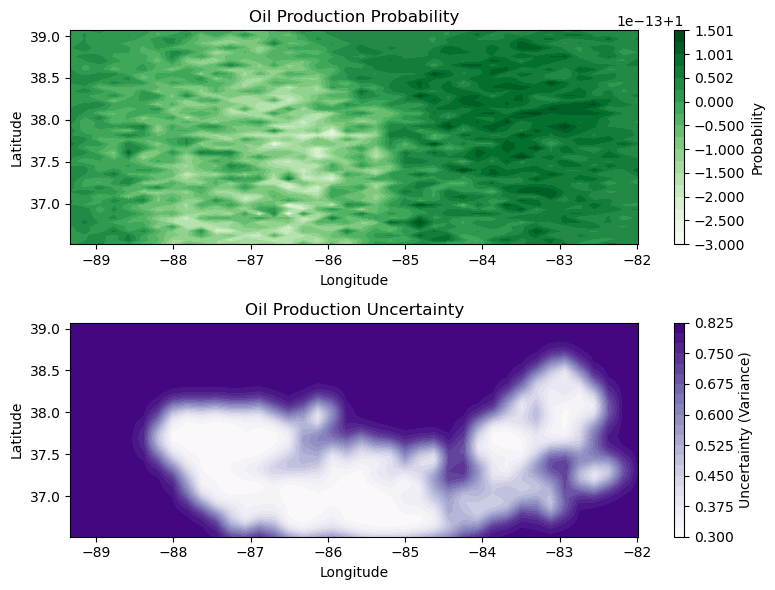

In [174]:
oil_prob, oil_var = perform_kriging(X_oil, Y_oil, oil_sample, grid_x, grid_y, var_model="gaussian", var_nugg=0.3, var_range=0.5, var_sill=0.8)
# Generate plots for each category with stacked subplots
plot_probability_uncertainty(grid_x, grid_y, oil_prob, oil_var, 
                             "Oil Production Probability", "Oil Production Uncertainty", 
                             cmap_prob="Greens", cmap_var="Purples")

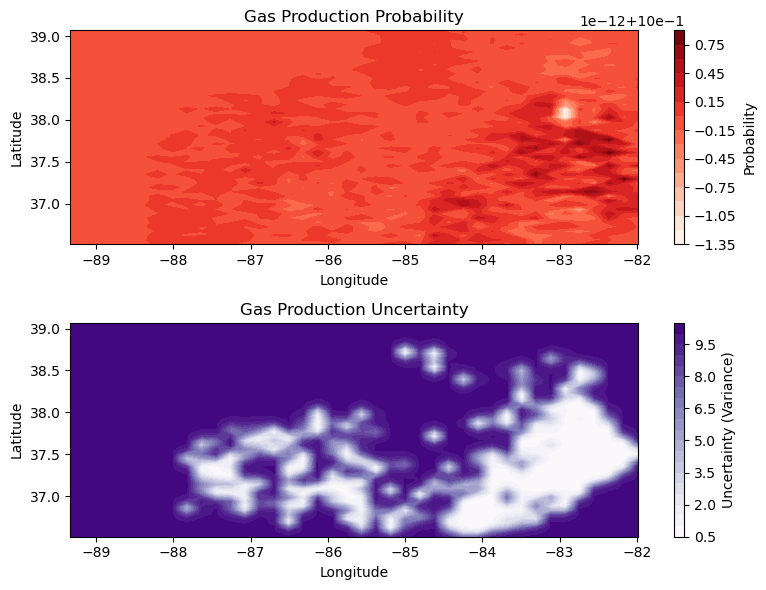

gas probability max/min [np.float64(0.9999999999986466), np.float64(1.0000000000008538)]


In [180]:
gas_prob, gas_var = perform_kriging(X_gas, Y_gas, gas_sample, grid_x, grid_y, var_model="gaussian", var_nugg=0.5, var_range=0.2, var_sill=10)
plot_probability_uncertainty(grid_x, grid_y, gas_prob, gas_var, 
                             "Gas Production Probability", "Gas Production Uncertainty", 
                             cmap_prob="Reds", cmap_var="Purples")
print("gas probability max/min", [gas_prob.min(), gas_prob.max()])

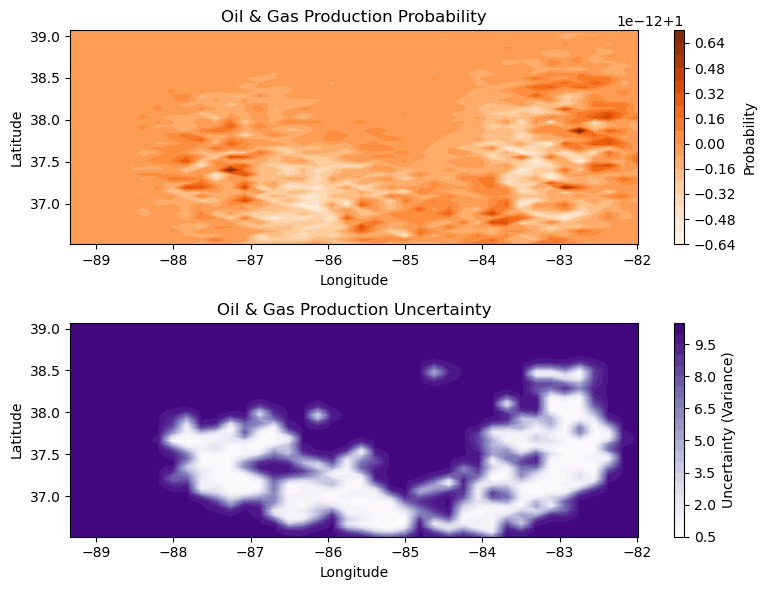

In [181]:
both_prob, both_var = perform_kriging(X_both, Y_both, both_sample, grid_x, grid_y, var_model="gaussian", var_nugg=0.5, var_range=0.2, var_sill=10)
plot_probability_uncertainty(grid_x, grid_y, both_prob, both_var, 
                             "Oil & Gas Production Probability", "Oil & Gas Production Uncertainty", 
                             cmap_prob="Oranges", cmap_var="Purples")